# Introduction to [JAX](https://github.com/google/jax)

<a href="https://colab.research.google.com/github/Ziaeemehr/workshop_hpcpy/blob/main/notebooks/jax/jax_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [3]:
# local setup
# !pip install -U jax  # cpu-only
!pip install -U "jax[cuda12]" # GPU, cuda 12.0

  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 MB 8.8 MB/s eta 0:00:00 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 8.7 MB/s eta 0:00:008.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 17.1 MB/s eta 0:00:00m eta 0:00:01:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.6 MB/s eta 0:00:00
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 58.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 87.3 MB/s eta 0:00:003 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 90

In [1]:
import os 
import jax 
jax.config.update("jax_enable_x64", True)  # default is 64-bit
# set jax to use cpu
jax.config.update('jax_platform_name', 'cpu') # gpu, to apply restart notebook

# and set to use all 4 cpu cores
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

# showing the device and number of available devices
jax.devices(), jax.local_device_count() 

([CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)], 4)

In [2]:
import jax 
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def cpu_timer():
    start = default_timer()
    yield
    end = default_timer()
    print(f'Elapsed time: {(end - start) * 1000} ms')

## NumPy functionality with JAX

In [4]:
import os
# os.environ['JAX_ENABLE_X64']='True'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
import numpy as np
import jax.numpy as jnp
import jax

In [5]:
x = jnp.arange(10)
y = jnp.arange(10, 20)
z = x + y

#### Euclidean distance matrix

$
    d_e(\mathbf x, \mathbf y) =
    \begin{bmatrix}
    \sum_{i=1}^n (x_{1i}-y_{1i})^2 & \sum_{i=1}^n(x_{1i}-y_{2i})^2 & \cdots & \sum_{i=1}^n (x_{1i}-y_{ni})^2 \\  
    \sum_{i=1}^n(x_{2i}-y_{1i})^2 & \sum_{i=1}^n(x_{2i}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{2i}-y_{ni})^2 \\  
    \vdots & \vdots & \ddots & \vdots \\
    \sum_{i=1}^n(x_{ni}-y_{1i})^2 & \sum_{i=1}^n(x_{ni}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{ni}-y_{ni})^2 \\  
    \end{bmatrix}
$

#### Vectorization friendly summation 
$ 
\sum_{k=1}^n \left(x_{ik}-y_{jk}\right)^2 = \left(\vec{x_i} - \vec {y_j}\right)\cdot \left(\vec{x_i} - \vec{y_j}\right)=\vec{x_i} \cdot \vec{x_i} + \vec{y_j} \cdot \vec{y_j} -2\vec{x_i}\cdot \vec{y_j}$


In [6]:
def euclidean_distance_np(x, y):
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    xy = x @ y.T
    return np.abs(x2 + y2 - 2.0 * xy)

def euclidean_distance_jax(x, y):
    x2 = jnp.einsum('ij,ij->i', x, x)[:, jnp.newaxis]
    y2 = jnp.einsum('ij,ij->i', y, y)[jnp.newaxis, :]
    xy = x @ y.T
    return jnp.abs(x2 + y2 - 2.0 * xy)

In [7]:
np_rng = np.random.default_rng()
x_np = np_rng.random((5000, 4000))
y_np = np_rng.random((5000, 4000))
x_gpu = jax.device_put(x_np).block_until_ready()
y_gpu = jax.device_put(y_np).block_until_ready()

with cpu_timer():
    eu_np = euclidean_distance_np(x_np, y_np)

with cpu_timer():
    eu_jax = euclidean_distance_jax(x_gpu, y_gpu).block_until_ready()
    
    
assert np.allclose(eu_np, jax.device_get(eu_jax))

Elapsed time: 5109.006642000168 ms
Elapsed time: 1384.507789000054 ms


### Immutability of JAX arrays

In [8]:
A = jnp.array([1., 2., 3., 4.])
B = jnp.array([2., 3., 4., 5.])

# This is not allowed
#A[2] = 10.0

A.at[2].set(10.0)

Array([ 1.,  2., 10.,  4.], dtype=float64)

In [9]:
print(A)

[1. 2. 3. 4.]


### Random number generation

In [10]:
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(key,(2, 2))
print(x)
print(y)

[[0.53222649 0.34965687]
 [0.35358648 0.95243876]]
[[0.53222649 0.34965687]
 [0.35358648 0.95243876]]


In [11]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

x = jax.random.uniform(key, (2, 2))
y = jax.random.uniform(subkey, (2, 2))
print(x)
print(y)

[[0.76976079 0.90799836]
 [0.03436751 0.08550389]]
[[0.52396976 0.29532386]
 [0.65223595 0.80683576]]


### Scaled Exponential Linear Unit (SELU) [Klambauer et al., 2017](https://arxiv.org/abs/1706.02515)


$$
f(x) =  \left\{
\begin{array}{ll}
      \lambda x & if & x \gt 0 \\
      \lambda \alpha (e^x - 1) & if & x \le 0 
\end{array} \right.
$$

$$
\begin{array}{ll}
    \alpha \simeq 1.67326 \\
    \lambda \simeq 1.050701
\end{array}
$$

SELU Cpu: Elapsed time: 144.80776399977913 ms


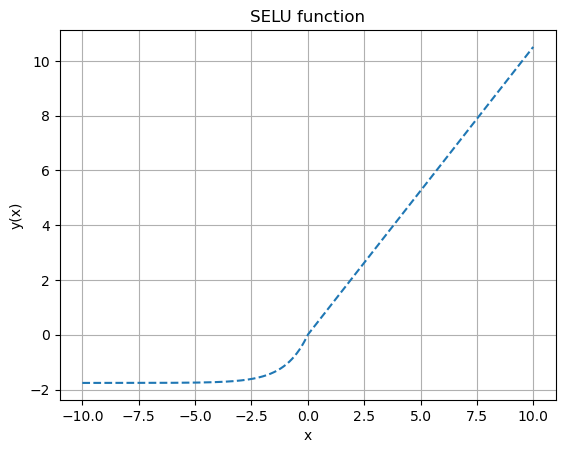

In [18]:
import matplotlib.pyplot as plt
from math import erfc, sqrt, exp, pi, e
x_np = np.linspace(-10.0, 10.0, 10_000_000)


alpha =  - sqrt(2.0 / pi) / (erfc(1 / sqrt(2)) * exp(1/2) - 1)
scale = (
    (1 - erfc(1 / sqrt(2)) * sqrt(e)) * sqrt(2 * pi) / 
    sqrt(2 * erfc(sqrt(2)) * e ** 2 + pi * e * erfc(1/sqrt(2)) ** 2 
         - 2 * (2 + pi)* erfc(1 / sqrt(2))*sqrt(e) + pi + 2)
)

def selu_cpu(x, a=alpha, l=scale):
    return np.where(x > 0, l * x, l * (a * np.exp(x) - a))

print('SELU Cpu: ', end='')
with cpu_timer():
    s_np = selu_cpu(x_np)
    
# Similar Functionality with cupy
'''
import cupy as cp
#x_gpu = cp.array(x_cpu)
selu_kernel = cp.ElementwiseKernel(
    'float64 X, float64 a, float64 l',
    'float64 selu',
    f'selu = X > 0 ? l * X : l * (a * exp(X) - a);', 
    'selu_kernel')
    
@cp.fuse
def selu_fused(x, a=alpha, l=scale):
    return cp.where(x > 0, l * x, l * (a * cp.exp(x) - a))

print('SELU Cpu: ', end='')
with cpu_timer():
    s_cpu = selu_cpu(x_cpu)
    
print('SELU Fused: ', end='')
with cupy_timer():
    s_gpu_fused = selu_fused(x_gpu)
    
print('SELU Kernel: ', end='')
with cupy_timer():
    s_gpu_kernel = selu_kernel(x_gpu, alpha, scale)
    
assert(np.allclose(s_cpu, s_gpu_fused.get()))
'''

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_np, s_np, '--');
ax.set_title('SELU function', )
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.grid('Both');

### (Exercise) Do the same with JAX and measure the performance